<a href="https://colab.research.google.com/github/angelamejia804/TimeSeries/blob/main/Modelo_Recepcion_Sarima_3_2020_2022.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import pandas as pd
import pylab as pl
import warnings
import itertools
import matplotlib.pyplot as plt
from sklearn.datasets import make_circles
from matplotlib.colors import Normalize
from time import time
import os
import datetime
import IPython
import IPython.display
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt


from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from pandas.plotting import register_matplotlib_converters

register_matplotlib_converters()
import warnings
warnings.filterwarnings('ignore')


mpl.rcParams['figure.figsize'] = (11, 4)
mpl.rcParams['axes.grid'] = False

import statsmodels.api as sm

plt.style.use('fivethirtyeight')

In [2]:
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import kpss

In [3]:
pip install pmdarima 

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 14.2 MB/s eta 0:00:00


In [4]:
from pmdarima.arima import auto_arima

# **Parametros estacionales**



1.   p : Orden autorregresivo.
2.   d : Orden de diferenciación.
3.   q : Orden de la media móvil.


# Parametros de temporada

*   P : Orden autorregresivo estacional.
*   D : Orden de diferenciación estacional.
*   P : Orden promedio móvil estacional
*   S : Duración del ciclo estacional.

https://www-jadsmkbdatalab-nl.translate.goog/forecasting-with-sarimax-models/?_x_tr_sl=en&_x_tr_tl=es&_x_tr_hl=es&_x_tr_pto=wapp


BASE DE DATOS DE RECEPCIÓN

Cargamos el archivo que se dejo preparado en el notebook
https://github.com/angelamejia804/TimeSeries/blob/main/Preparacion_TimeSeries_Recepcion_2_1.ipynb



In [5]:
from google.colab import files
uploaded = files.upload()

Saving df_recepcion_traint.csv to df_recepcion_traint.csv


In [6]:
df_r = pd.read_csv("df_recepcion_traint.csv", delimiter=';',index_col='Semana')

In [82]:
df_r = df_r['2021-W01':]

In [83]:
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import kpss

def obtain_adf_kpss_results(timeseries, max_d):
    """ Build dataframe with ADF statistics and p-value for time series after applying difference on time series
    
    Args:
        time_series (df): Dataframe of univariate time series  
        max_d (int): Max value of how many times apply difference
        
    Return:
        Dataframe showing values of ADF statistics and p when applying ADF test after applying d times 
        differencing on a time-series.
    
    """
    
    results=[]

    for idx in range(max_d):
        adf_result = adfuller(timeseries, autolag='AIC')
        kpss_result = kpss(timeseries, regression='c', nlags="auto")
        timeseries = timeseries.diff().dropna()
        if adf_result[1] <=0.05:
            adf_stationary = True
        else:
            adf_stationary = False
        if kpss_result[1] <=0.05:
            kpss_stationary = False
        else:
            kpss_stationary = True
            
        stationary = adf_stationary & kpss_stationary
            
        results.append((idx,adf_result[1], kpss_result[1],adf_stationary,kpss_stationary, stationary))
    
    # Construct DataFrame 
    results_df = pd.DataFrame(results, columns=['d','adf_stats','p-value', 'is_adf_stationary','is_kpss_stationary','is_stationary' ])
    
    return results_df
    #esta funcion fue tomada de  

In [84]:
df_r.head()

,Tallos
Semana,
2021-W01,389471
2021-W02,198685
2021-W03,423367
2021-W04,930583
2021-W05,845326


In [85]:
df_r.describe()

,Tallos
count,104.000000
mean,282109.817308
std,165216.534624
min,72136.000000
25%,176318.000000
50%,235049.500000
75%,322169.250000
max,930583.000000


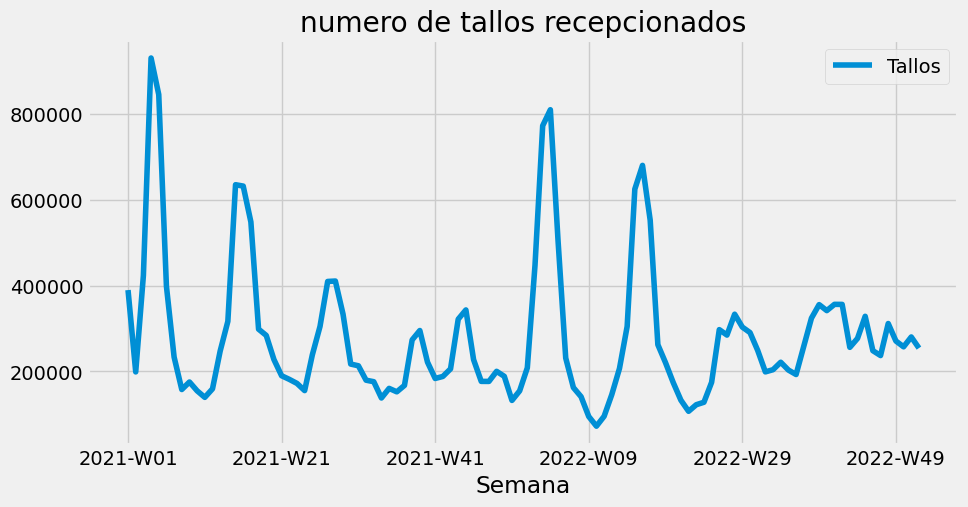

In [86]:
# Plot the entire time series diet and show gridlines
df_r.plot(figsize=(10,5), title = "numero de tallos recepcionados" )
plt.show()

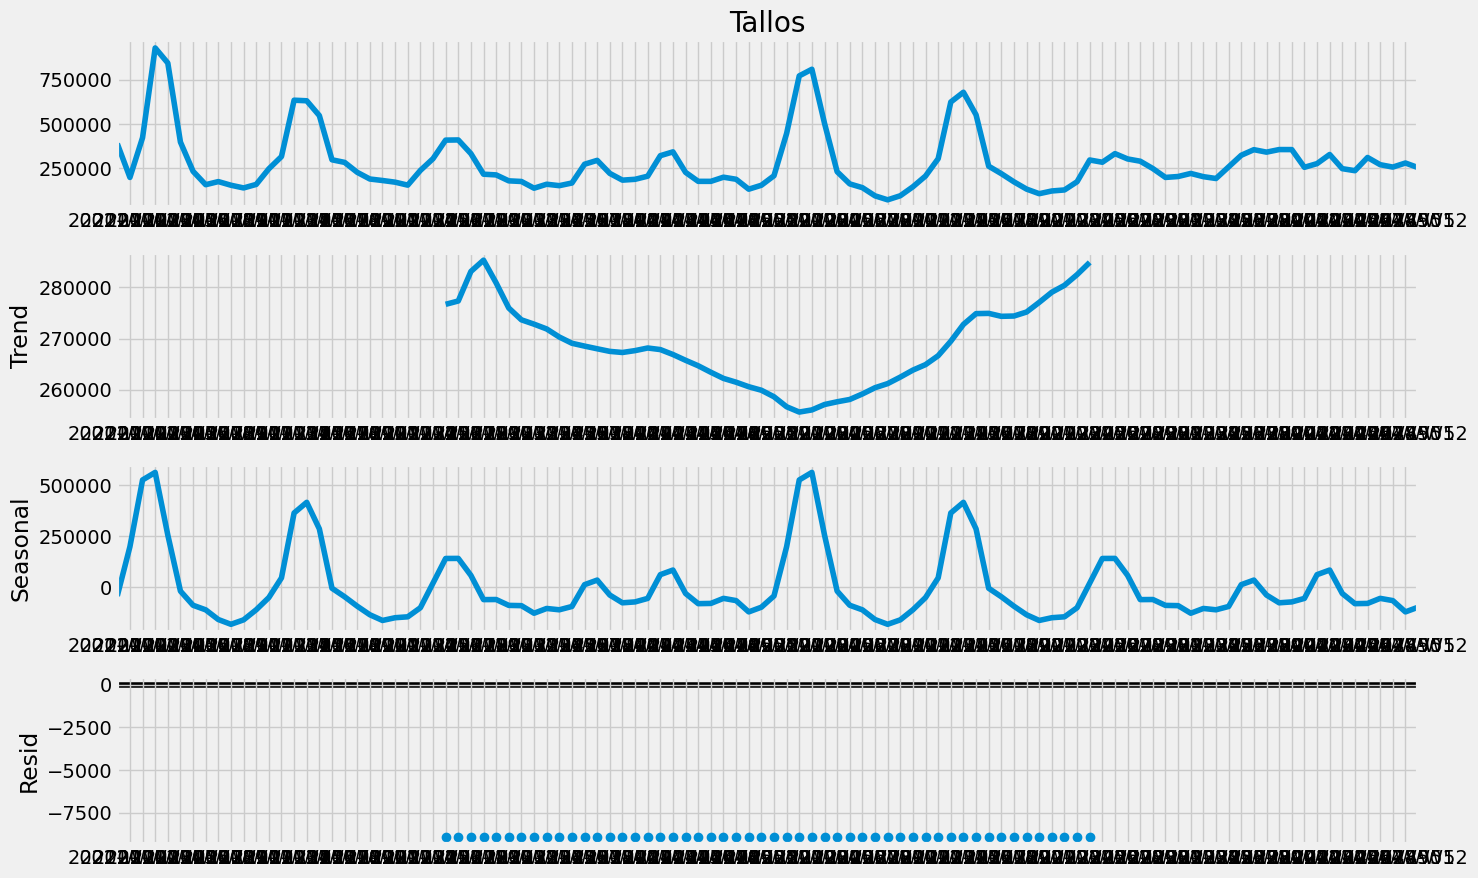

In [89]:
from pylab import rcParams
rcParams['figure.figsize'] = 15, 9

import statsmodels.api as sm
decomposition = sm.tsa.seasonal_decompose(df_r['Tallos'],
                                         ###model = 'multiplicative', #   model = 'aditive',
                                         period=52 #52 to 53 weeks in a year
                                         )
fig = decomposition.plot()
plt.show()

pruebas para determinar si la serie es

In [90]:
obtain_adf_kpss_results(df_r,3) #no se requiere ya que con d=0 cumple

,d,adf_stats,p-value,is_adf_stationary,is_kpss_stationary,is_stationary
0,0,5.048415e-02,0.1,False,True,False
1,1,6.138871e-15,0.1,True,True,True
2,2,1.699059e-12,0.1,True,True,True


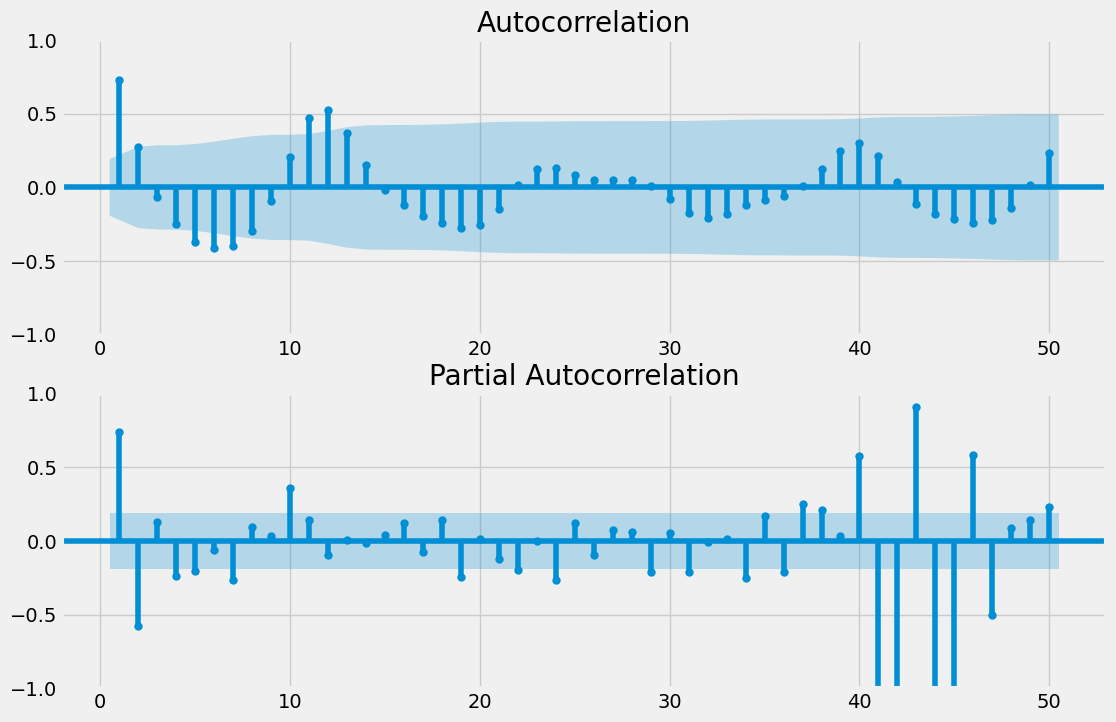

In [93]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Create figure
fig, (ax1, ax2) = plt.subplots(2,1, figsize=(12,8))
 
# Plot the ACF of df_store_2_item_28_timeon ax1
plot_acf(df_r,lags=50, zero=False, ax=ax1)

# Plot the PACF of df_store_2_item_28_timeon ax2
plot_pacf(df_r,lags=50, zero=False, ax=ax2)

plt.show()



Probemos definir el modelo con a traves de los criterios AIC y BIC



In [94]:
# Create empty list to store search results
order_aic_bic=[]

# Loop over p values from 0-6
for p in range(8):
  # Loop over q values from 0-6
    for q in range(7):
      	#  fit ARMA(p,q) model
        model = SARIMAX(df_r, order=(p,0,q),  Frequency='W') #
        results = model.fit()
        
        # 
        order_aic_bic.append((p,q,results.aic, results.bic))

# Construct DataFrame from order_aic_bic
order_df = pd.DataFrame(order_aic_bic, 
                        columns=['p','q','AIC','BIC'])

In [95]:
order_df.sort_values('AIC')# 3	1	4103.791292	4119.040572  / 3	1	4103.791292	4119.040572

,p,q,AIC,BIC
43,6,1,2679.710417,2700.865544
51,7,2,2683.571078,2710.014987
10,1,3,2683.883652,2697.105606
44,6,2,2684.142421,2707.941939
54,7,5,2684.941381,2719.318462
13,1,6,2685.729440,2706.884567
12,1,5,2685.810529,2704.321265
17,2,3,2687.441881,2703.308227
23,3,2,2689.168448,2705.034793
11,1,4,2690.254285,2706.120631


In [96]:
order_df.sort_values('BIC')

,p,q,AIC,BIC
10,1,3,2683.883652,2697.105606
43,6,1,2679.710417,2700.865544
17,2,3,2687.441881,2703.308227
12,1,5,2685.810529,2704.321265
23,3,2,2689.168448,2705.034793
11,1,4,2690.254285,2706.120631
13,1,6,2685.729440,2706.884567
44,6,2,2684.142421,2707.941939
21,3,0,2697.702531,2708.280094
51,7,2,2683.571078,2710.014987


In [97]:
arima_model = SARIMAX(df_r, order=(6,0,1))   #  (3,0,1))   
# fit model
arima_results = arima_model.fit()

# Calculate the mean absolute error from residuals
mae = np.mean(np.abs(arima_results.resid))

# Print mean absolute error
print('MAE: %.3f' % mae)

MAE: 68735.071


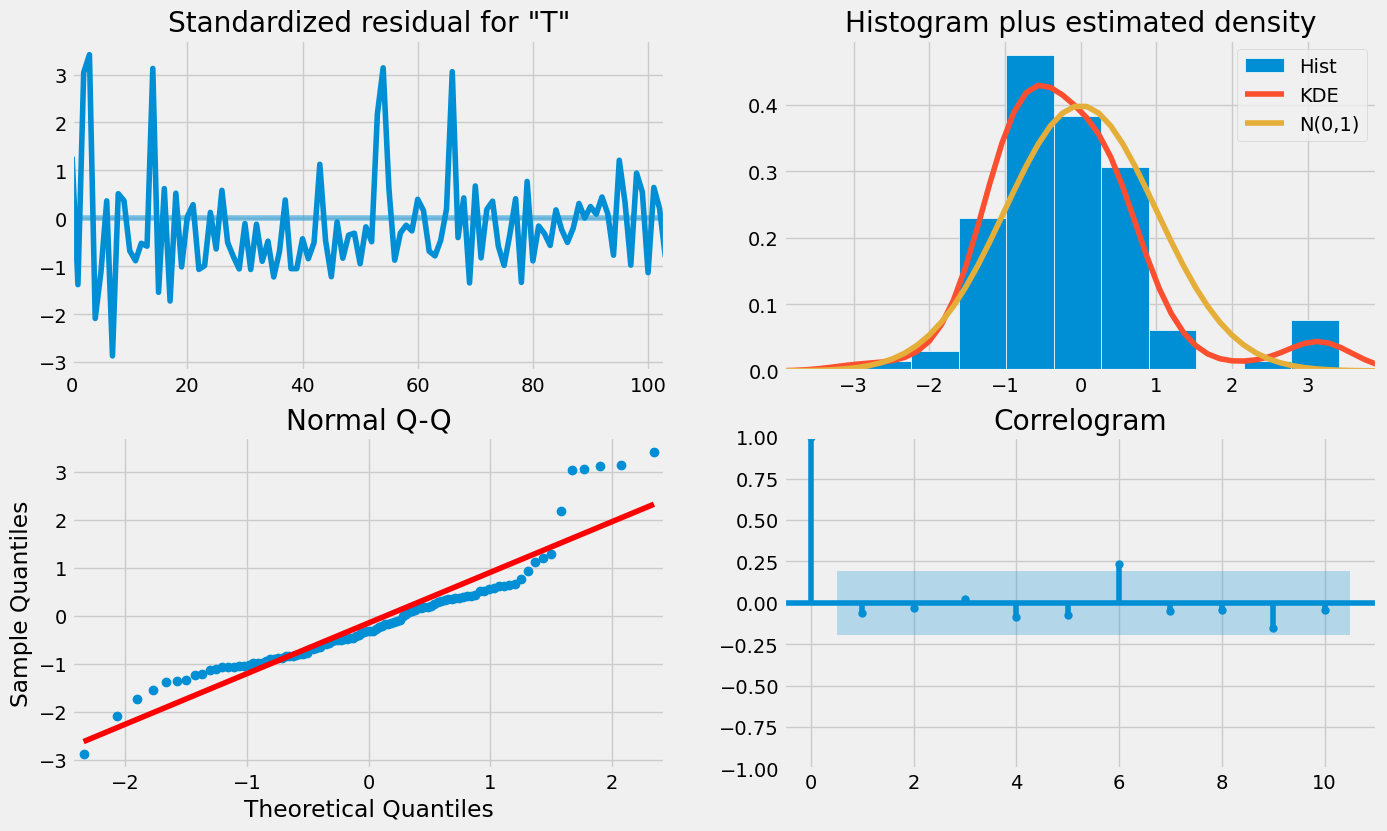

In [98]:
arima_results.plot_diagnostics()
plt.show()

In [99]:
sarima_01_model = SARIMAX(df_r, order=(6,0,1), seasonal_order=(6,0,1,52))
sarima_01_results = sarima_01_model.fit()

# Calculate the mean absolute error from residuals
mae = np.mean(np.abs(sarima_01_results.resid))

# Print mean absolute error
print('MAE: %.3f' % mae)

MAE: 64339.642


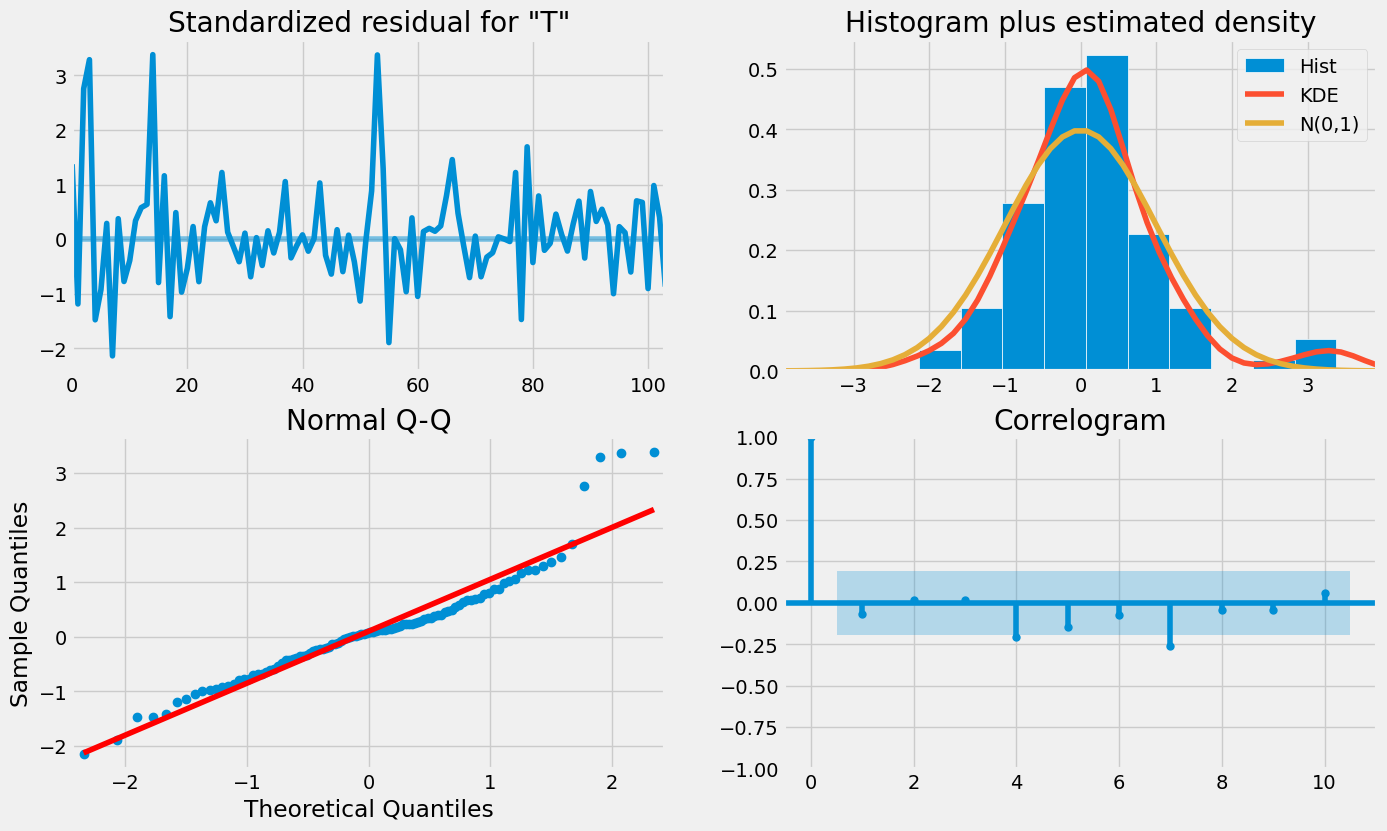

In [100]:
sarima_01_results.plot_diagnostics()
plt.show()

hacemos un intento a traves de la seleccion automatizada - Auto Arima

In [102]:
from pmdarima.arima.arima import pmdarima
sarima_02_model=pmdarima.auto_arima(df_r, #time series
                      seasonal=True, # is the time series seasonal
                      m=52, # the seasonal period - 53  weeks?
                      d=0, # non-seasonal difference order
                      D=0, # seasonal difference order
                 	  max_p=6, # max value of p to test 
                      max_q=6, # max value of p to test
                      max_P=6, # max value of P to test 
                      max_Q=6, # max value of Q to test 
                      information_criterion='aic', # used to select best mode
                      trace=True, # prints the information_criterion for each model it fits
                      error_action='ignore', # ignore orders that don't work
                      stepwise=True, # apply an intelligent order search
                      suppress_warnings=True) 

# Print model summary
print(sarima_02_model.summary())

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(1,0,1)[52] intercept   : AIC=2658.808, Time=8.99 sec
 ARIMA(0,0,0)(0,0,0)[52] intercept   : AIC=2797.257, Time=0.04 sec
 ARIMA(1,0,0)(1,0,0)[52] intercept   : AIC=2707.999, Time=1.40 sec
 ARIMA(0,0,1)(0,0,1)[52] intercept   : AIC=2714.886, Time=0.78 sec
 ARIMA(0,0,0)(0,0,0)[52]             : AIC=2937.963, Time=0.03 sec
 ARIMA(2,0,2)(0,0,1)[52] intercept   : AIC=inf, Time=3.51 sec
 ARIMA(2,0,2)(1,0,0)[52] intercept   : AIC=2657.134, Time=2.51 sec
 ARIMA(2,0,2)(0,0,0)[52] intercept   : AIC=2698.810, Time=0.19 sec
 ARIMA(2,0,2)(2,0,0)[52] intercept   : AIC=2658.743, Time=13.73 sec
 ARIMA(2,0,2)(2,0,1)[52] intercept   : AIC=2660.726, Time=24.35 sec
 ARIMA(1,0,2)(1,0,0)[52] intercept   : AIC=2655.008, Time=2.21 sec
 ARIMA(1,0,2)(0,0,0)[52] intercept   : AIC=2697.790, Time=0.07 sec
 ARIMA(1,0,2)(2,0,0)[52] intercept   : AIC=2656.857, Time=9.40 sec
 ARIMA(1,0,2)(1,0,1)[52] intercept   : AIC=2656.906, Time=2.39 sec
 ARIMA(1,0,2)(0,0,1)[5

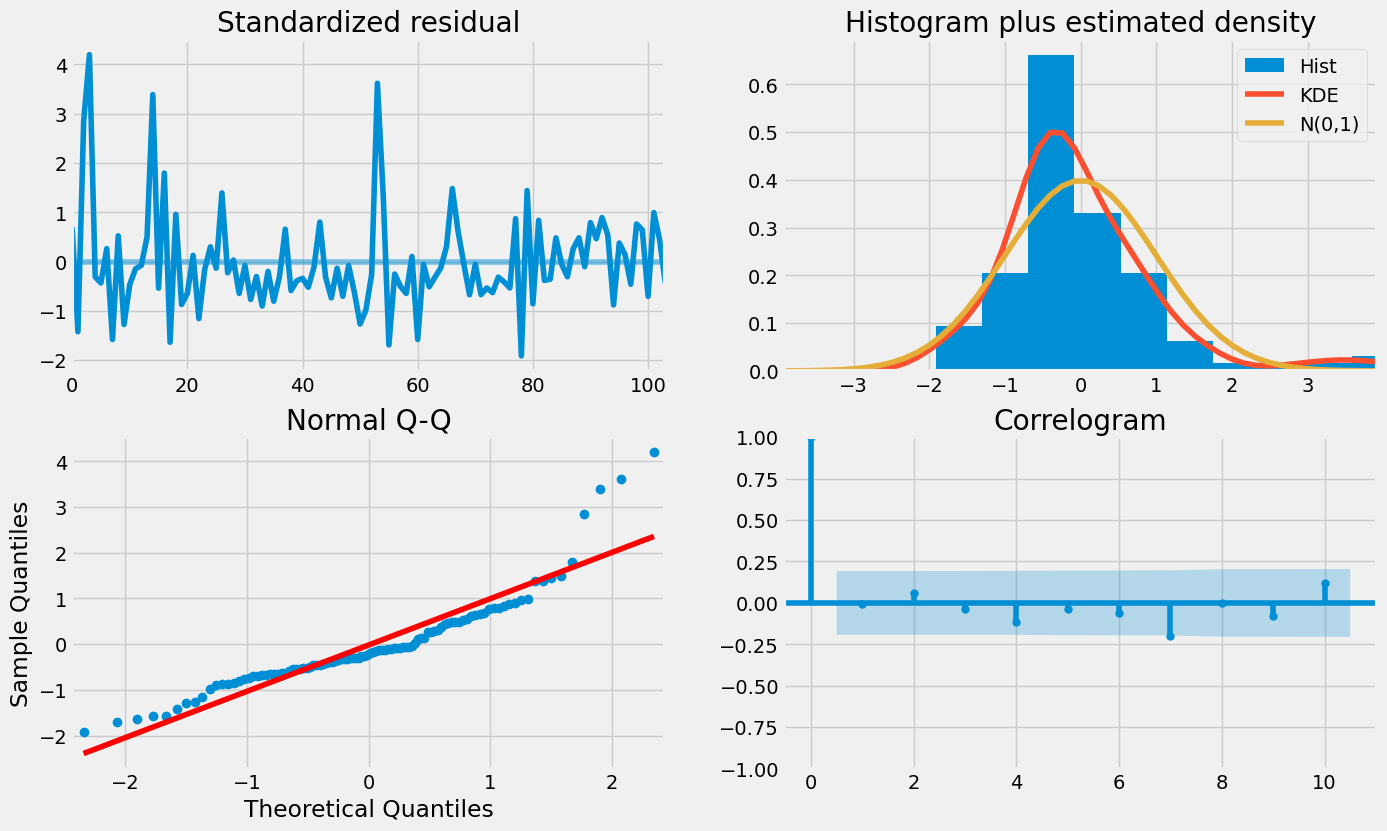

In [103]:
sarima_02_model.plot_diagnostics()
plt.show()

Best model:  ARIMA(2,0,0)(2,0,0)[53] intercept

Best model:  ARIMA(2,0,0)(2,0,0)[53] intercept 

1.   Elemento de lista
2.   Best model:  ARIMA(1,0,2)(1,0,0)[52] intercept   - datos 2021-2022



---





In [104]:
sarima_02_model = SARIMAX(df_r, order=(1,0,2), seasonal_order=(1,0,0,52))
sarima_02_results = sarima_02_model.fit()

# Calculate the mean absolute error from residuals
mae = np.mean(np.abs(sarima_02_results.resid))

# Print mean absolute error
print('MAE: %.3f' % mae)

MAE: 68892.413


In [105]:
# Create ARIMA mean forecast
arima_pred = arima_results.get_prediction(start=-30, dynamic=True)
arima_mean = arima_pred.predicted_mean

# Create SARIMA mean forecast
sarima_01_pred = sarima_01_results.get_prediction(start=-30, dynamic=True)
sarima_01_mean = sarima_01_pred.predicted_mean

#autorarima

sarima_02_pred = sarima_01_results.get_prediction(start=-30, dynamic=True)
sarima_02_mean = sarima_02_pred.predicted_mean


In [106]:
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error

metrics_arima = [round(mean_absolute_error(df_r[-30:],arima_mean),3), 
                 round(mean_absolute_percentage_error(df_r[-30:],arima_mean),3)]

metrics_sarima_01 = [round(mean_absolute_error(df_r[-30:],sarima_01_mean),3), 
                       round(mean_absolute_percentage_error(df_r[-30:],sarima_01_mean),3)]



In [107]:
y_true = df_r[-30:]  # Valores reales de la serie de tiempo
r2_Arima = round(r2_score(y_true, arima_mean), 3)
r2__sarima_01 = round(r2_score(y_true, sarima_01_mean), 3)
r2__sarima_02 = round(r2_score(y_true,sarima_02_mean), 3)


In [108]:
print(metrics_arima) 
print(metrics_sarima_01) 
print(metrics_sarima_02) 

[44450.804, 0.202]
[111813.083, 0.403]
[34131.146, 0.116]


In [109]:
print(r2_Arima)
print(r2__sarima_01)
print(r2__sarima_02)

0.21
-3.103
-3.103


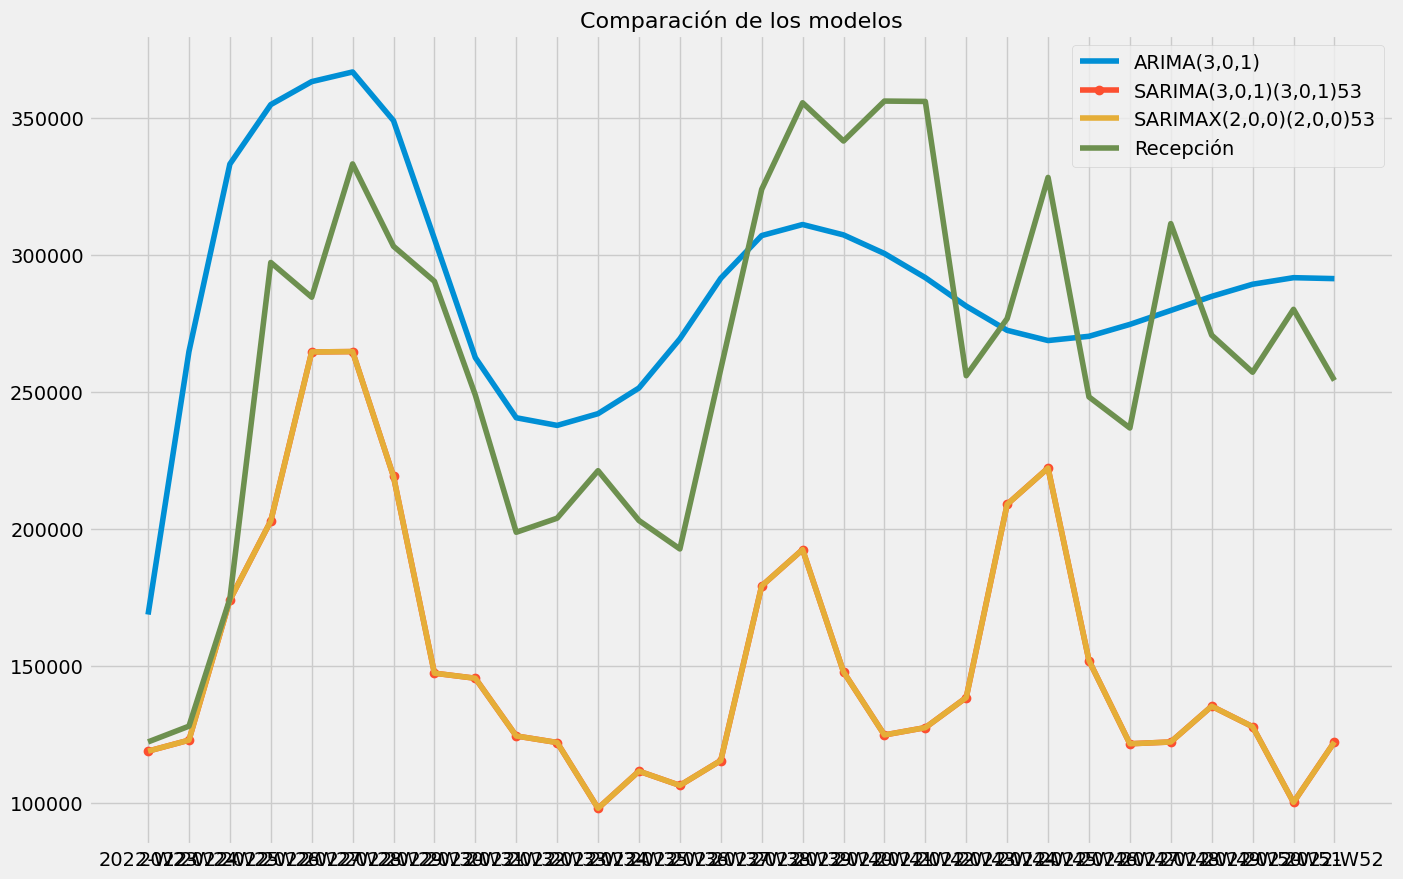

In [110]:
dates = df_r.index
#comparamos los modelos contra los valores observados
plt.figure(figsize=(15,10))
plt.title('Comparación de los modelos', size = 16)
plt.plot(arima_mean.index, arima_mean, label='ARIMA(3,0,1)')
plt.plot(sarima_01_mean.index, sarima_01_mean, label='SARIMA(3,0,1)(3,0,1)53', marker='o')
plt.plot(sarima_02_mean.index, sarima_02_mean, label='SARIMAX(2,0,0)(2,0,0)53')
plt.plot(df_r[-30:], label='Recepción')
plt.legend()
plt.show()

In [111]:
# Create ARIMA mean forecast
arima_pred = arima_results.get_forecast(steps=13)
arima_mean = arima_pred.predicted_mean


In [112]:
arima_mean

104    226955.770821
105    230973.250383
106    264972.772626
107    284619.709901
108    283508.513555
109    281845.446245
110    290537.983402
111    294841.396412
112    285105.202859
113    270878.616912
114    264967.506821
115    266034.826402
116    266164.033673
Name: predicted_mean, dtype: float64